In [66]:
import numpy as np
from scipy import stats
import pandas as pd
import torch
import gpytorch
from tqdm import tqdm_notebook

# For plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
from collections import defaultdict
%matplotlib inline

In [2]:
# Load the data
df_train = pd.read_pickle('../preprocessing/training_data.pkl')
df_validate = pd.read_pickle('../preprocessing/validation_data.pkl')
df_catalog = pd.read_pickle('../preprocessing/catalog_data.pkl')

# Convert the data into tensors
train_x = torch.Tensor(df_train.values[:, :-1]).contiguous().cuda()
train_y = torch.Tensor(df_train.values[:, -1]).cuda()
validate_x = torch.Tensor(df_validate.values[:, :-1]).cuda()
validate_y = torch.Tensor(df_validate.values[:, -1]).cuda()
catalog_x = torch.Tensor(df_catalog.values).cuda()

In [3]:
print(train_x.shape)
print(validate_x.shape)

torch.Size([13651, 40])
torch.Size([3413, 40])


In [4]:
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.base_covar_module = ScaleKernel(RBFKernel())
        self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=train_x[:500, :], likelihood=likelihood)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

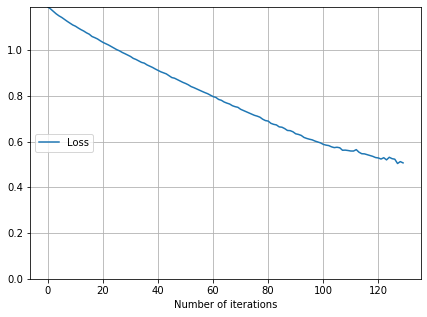

CPU times: user 30.3 s, sys: 2.66 s, total: 33 s
Wall time: 22.2 s


In [5]:
# Initialize the model
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
model = GPRegressionModel(train_x, train_y, likelihood).cuda()

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Function to make dynamic learning curve
def live_plot(data_dict, figsize=(7, 5), title=''):
    ''' Credit to Ziofil on StackOverflow '''
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label, data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Number of iterations')
    plt.legend(loc='center left') # the plot evolves to the right
    ax = plt.gca()
    ax.set_ylim(0, max(max(data) for data in data_dict.values()))
    plt.show()

def train(training_iterations=25):
    # Train the model
    learning_curve_data = defaultdict(list)
    for i in range(training_iterations):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        # Update the learning curve
        learning_curve_data['Loss'].append(loss.item())
        live_plot(learning_curve_data)

%time train(130)

In [6]:
model.eval()
likelihood.eval()
with gpytorch.settings.max_preconditioner_size(10), torch.no_grad():
    with gpytorch.settings.use_toeplitz(False), gpytorch.settings.max_root_decomposition_size(30), gpytorch.settings.fast_pred_var():
        preds = model(validate_x)

In [7]:
residuals = preds.mean - validate_y
standard_errors = preds.stddev
mae = torch.mean(torch.abs(residuals))

standard_errors = standard_errors.cpu().detach().numpy()
residuals = residuals.cpu().numpy()

print('Validation MAE: {}'.format(mae))

Validation MAE: 0.30272936820983887


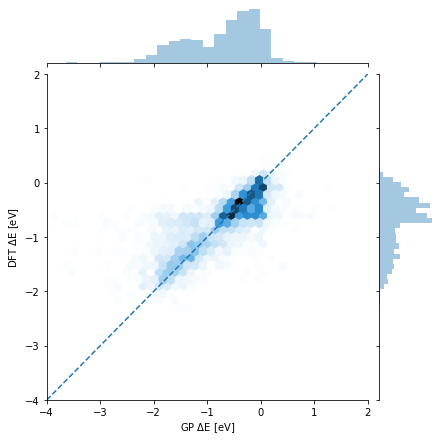

In [24]:
validate_y_np = validate_y.cpu().numpy()
grid = sns.jointplot(validate_y_np, validate_y_np+residuals,
                     kind='hex',
                     #bins='log',
                     extent=[-4, 2, -4, 2])
_ = grid.ax_joint.set_xlim([-4, 2])
_ = grid.ax_joint.set_ylim([-4, 2])
_ = grid.ax_joint.plot([-4, 2], [-4, 2], '--')
_ = grid.ax_joint.set_xlabel('GP $\Delta$E [eV]')
_ = grid.ax_joint.set_ylabel('DFT $\Delta$E [eV]')

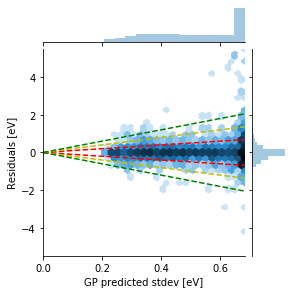

In [77]:
import seaborn as sns

se_lims = (0, max(standard_errors))
resid_lims = (-max(abs(residuals)), max(abs(residuals)))
#resid_lims = (-3*se_lims[1], 3*se_lims[1])

jgrid = sns.jointplot(x=standard_errors, y=residuals, kind='hex', height=4, bins='log',
                      extent=[se_lims[0], se_lims[1], -resid_lims[1], resid_lims[1]])
_ = jgrid.ax_joint.plot([se_lims[0], se_lims[1]], [se_lims[0],  1*se_lims[1]], 'r--')
_ = jgrid.ax_joint.plot([se_lims[0], se_lims[1]], [se_lims[0],  2*se_lims[1]], 'y--')
_ = jgrid.ax_joint.plot([se_lims[0], se_lims[1]], [se_lims[0],  3*se_lims[1]], 'g--')
_ = jgrid.ax_joint.plot([se_lims[0], se_lims[1]], [se_lims[0], -1*se_lims[1]], 'r--')
_ = jgrid.ax_joint.plot([se_lims[0], se_lims[1]], [se_lims[0], -2*se_lims[1]], 'y--')
_ = jgrid.ax_joint.plot([se_lims[0], se_lims[1]], [se_lims[0], -3*se_lims[1]], 'g--')
_ = jgrid.ax_joint.set_xlim(se_lims)
_ = jgrid.ax_joint.set_ylim(resid_lims)
_ = jgrid.ax_joint.set_xlabel('GP predicted stdev [eV]')
_ = jgrid.ax_joint.set_ylabel('Residuals [eV]')

In [72]:
norms = [stats.norm(loc=0, scale=se)
         for se in tqdm_notebook(standard_errors, desc='Norms')]

In [73]:
def calculate_density(percentile):
    num_within_quantile = 0
    for se, resid, norm in zip(standard_errors, residuals, norms):
        lower_bound = dist.ppf(0.5-percentile/2)
        upper_bound = dist.ppf(0.5+percentile/2)
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1
    density = num_within_quantile / len(residuals)
    return density

predicted_pi = np.linspace(0, 1, 20)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

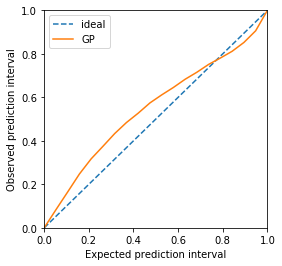

In [84]:
fig = plt.figure(figsize=(4, 4))
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label='GP')
_ = ax_gp.set_xlabel('Expected prediction interval')
_ = ax_gp.set_ylabel('Observed prediction interval')
_ = ax_gp.set_xlim([0, 1])
_ = ax_gp.set_ylim([0, 1])

In [87]:
sharpness = np.mean(standard_errors**2)
print('Sharpness = %.2f eV^2' % sharpness)

Sharpness = 0.28 eV^2
